# TODO
 - Check the mainstream order of original weight

In [1]:
%matplotlib inline

import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from scipy import ndimage
import cmath
import math
import Image
from keras.datasets import mnist
from collections import Counter

def resize(input_im):
    im = Image.fromarray(input_im)
    im = im.resize([10,10], Image.ANTIALIAS)
    rz_im = np.asarray((im.getdata()))
    return np.reshape(rz_im, (10,10))

def getXsvd(imgmat,k):
    U, sigma, V = np.linalg.svd(imgmat)
    reconstimg = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
#     plt.imshow(reconstimg, cmap='gray')
    return reconstimg
    
def getX_10():    
    X_10_train = np.zeros((60000,10,10))
    X_10_test =  np.zeros((10000,10,10))
    (X_train, _), (X_test, _) = mnist.load_data()
    for i in range(X_train.shape[0]):
        X_10_train[i,:,:] = resize(X_train[i])
    for i in range(X_test.shape[0]):
        X_10_test[i,:,:] = resize(X_test[i])
    return X_10_train,X_10_test

def get_mode_by_order(w):
    data = Counter(w.flatten())
    mode_w = data.most_common(len(data))  # Returns the highest occurring item
    
    dic = {}

    for num in mode_w:
        for j in [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000, 1000000000000000, 10000000000000000, 100000000000000000, 1000000000000000000, 10000000000000000000L, 100000000000000000000L, 1000000000000000000000L, 10000000000000000000000L, 100000000000000000000000L, 1000000000000000000000000L, 10000000000000000000000000L, 100000000000000000000000000L, 1000000000000000000000000000L, 10000000000000000000000000000L, 100000000000000000000000000000L]:
            res = abs(num[0] * j)
            if res >= 1 and res < 10:
                dic[j] = dic.get(j,0)+1
    
    return dic.iteritems()        

def get_lw(l_wrt_w):
    loss = np.zeros((512,10))
    weights = np.zeros((512,10))

    for i in range(512):
        for j in range(10):
            loss[i,j] = l_wrt_w[i,j,0]
            weights[i,j] = l_wrt_w[i,j,1]    
    return loss,weights

Using Theano backend.


# Playing with last layer (only Dense10)

In [4]:
from __future__ import print_function
import numpy as np
import random
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2, activity_l2


batch_size = 512
nb_classes = 10
nb_epoch = 256

train_slice = 1000
test_slice = 10000


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

X_train_10000 = X_train[:train_slice]
X_test_10000 = X_test[:test_slice]

print(X_train_10000.shape[0], 'train samples')
print(X_test_10000.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train[:train_slice], nb_classes)
Y_test = np_utils.to_categorical(y_test[:test_slice], nb_classes)

FC0 = Dense(512, input_shape=(784,))
FC1 = Dense(512)
FC2 = Dense(10)

model = Sequential()
model.add(FC0)
model.add(Activation('relu'))
model.add(FC1)
model.add(Activation('relu'))
model.add(FC2)
model.add(Activation('softmax'))

model.summary()

model.compile(loss='mse',
              optimizer='adadelta',
              metrics=['accuracy'])

history = model.fit(X_train_10000, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test_10000, Y_test))
score = model.evaluate(X_test_10000, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
test_score = score[0]

score = model.evaluate(X_train_10000, Y_train, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1000 train samples
10000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 512)           401920      dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 512)           0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 512)           262656      activation_4[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 512)           0           dense_5[0][0]                    
_____________________________________________________

In [7]:
layers_weights = [model.layers[0].get_weights(), model.layers[2].get_weights(),model.layers[4].get_weights()]
orignial_layers_weight = np.copy(layers_weights)

l4_alt_10 = np.copy(layers_weights[2])
l_wrt_w_10 = np.zeros(layers_weights[2][0].shape + (2,))

l4_alt_100 = np.copy(layers_weights[2])
l_wrt_w_100 = np.zeros(layers_weights[2][0].shape + (2,))

l4_alt_200 = np.copy(layers_weights[2])
l_wrt_w_200 = np.zeros(layers_weights[2][0].shape + (2,))

model.layers[0].set_weights(layers_weights[0])
model.layers[2].set_weights(layers_weights[1])

# Change the weight only 1 at the time
# evaluate the loss thru the network
# - calculate diff of 
#   - 1) Test Score 
#   - 2) Weight difference (From the original and the altered one[/10 and /100])
# set the weight back 

for idx in [0,2,4]:
    model.layers[idx].trainable = False

for i in range(l_wrt_w_10.shape[0]):
    for j in range(l_wrt_w_10.shape[1]):
        
        # keep the originial weight, so we don't need to do the math & reference twice(*10, /10)
        w_dummy = orignial_layers_weight[2][0][i][j]
        print("w_dummy = ", w_dummy)
        
        # make it ten times much bigger or smaller, see how to changes the network
        l4_alt_10[0][i][j] /= 10
        l4_alt_100[0][i][j] /= 100
        l4_alt_200[0][i][j] /= 200
        
        print("much compute = ",  l4_alt_10[0][i][j], l4_alt_100[0][i][j], l4_alt_200[0][i][j])

        # set the weight/100 to the network, and evaluate the score
        model.layers[4].set_weights(l4_alt_10)
        score_10 = model.evaluate(X_test_10000, Y_test, verbose=0)
        
        # set the weight/100 to the network, and evaluate the score
        model.layers[4].set_weights(l4_alt_100)
        score_100 = model.evaluate(X_test_10000, Y_test, verbose=0)
        
        # set the weight/100 to the network, and evaluate the score
        model.layers[4].set_weights(l4_alt_200)
        score_200 = model.evaluate(X_test_10000, Y_test, verbose=0)
        
        l_wrt_w_10[i][j][0] = test_score - score_10[0]
        l_wrt_w_10[i][j][1] = w_dummy - l4_alt_10[0][i][j]
        
        l_wrt_w_100[i][j][0] = test_score - score_100[0]
        l_wrt_w_100[i][j][1] = w_dummy - l4_alt_100[0][i][j]
        
        l_wrt_w_200[i][j][0] = test_score - score_200[0]
        l_wrt_w_200[i][j][1] = w_dummy - l4_alt_200[0][i][j]
        
        if (j%5 == 0 and i%5 == 0):
            print("i,j,w_dummy,l4_alt_10,100,200 = ", i, j, w_dummy, l4_alt_10[0][i][j], l4_alt_100[0][i][j], l4_alt_200[0][i][j])
        
        # set the weight back
        l4_alt_10[0][i][j] = w_dummy
        l4_alt_100[0][i][j] = w_dummy
        l4_alt_200[0][i][j] = w_dummy

w_dummy =  0.125768
much compute =  6.28841e-07 6.28841e-07 6.28841e-07
i,j,w_dummy,l4_alt_10,100,200 =  0 0 0.125768 6.28841e-07 6.28841e-07 6.28841e-07
w_dummy =  -0.022948
much compute =  -1.1474e-07 -1.1474e-07 -1.1474e-07
w_dummy =  -0.00369902
much compute =  -1.84951e-08 -1.84951e-08 -1.84951e-08
w_dummy =  0.124609
much compute =  6.23045e-07 6.23045e-07 6.23045e-07
w_dummy =  -0.0833119
much compute =  -4.16559e-07 -4.16559e-07 -4.16559e-07
w_dummy =  -0.0625293
much compute =  -3.12647e-07 -3.12647e-07 -3.12647e-07
i,j,w_dummy,l4_alt_10,100,200 =  0 5 -0.0625293 -3.12647e-07 -3.12647e-07 -3.12647e-07
w_dummy =  -0.0788978
much compute =  -3.94489e-07 -3.94489e-07 -3.94489e-07
w_dummy =  0.107732
much compute =  5.38659e-07 5.38659e-07 5.38659e-07


KeyboardInterrupt: 

# Save the l_wrt_w in file

In [ ]:
import pickle

with open('l_wrt_w_10_newscript', 'wb') as handle:
    pickle.dump(l_wrt_w_10, handle)
    
with open('l_wrt_w_100_newscript', 'wb') as handle:
    pickle.dump(l_wrt_w_100, handle)
    
with open('l_wrt_w_200_newscript', 'wb') as handle:
    pickle.dump(l_wrt_w_200, handle)

# pf = open('l_wrt_w_lastlayer_9888','rb')
# l_wrt_w = pickle.load(pf)

In [11]:
l_diff = np.zeros((512,10))
w_diff = np.zeros((512,10))

l_diff100 = np.zeros((512,10))
w_diff100 = np.zeros((512,10))

for i in range(l_wrt_w_10.shape[0]):
    for j in range(l_wrt_w_10.shape[1]):
        l_diff[i,j] = l_wrt_w_10[i,j,0]
        w_diff[i,j] = l_wrt_w_10[i,j,1]
        l_diff100[i,j] = l_wrt_w_100[i,j,0]
        w_diff100[i,j] = l_wrt_w_100[i,j,1]        

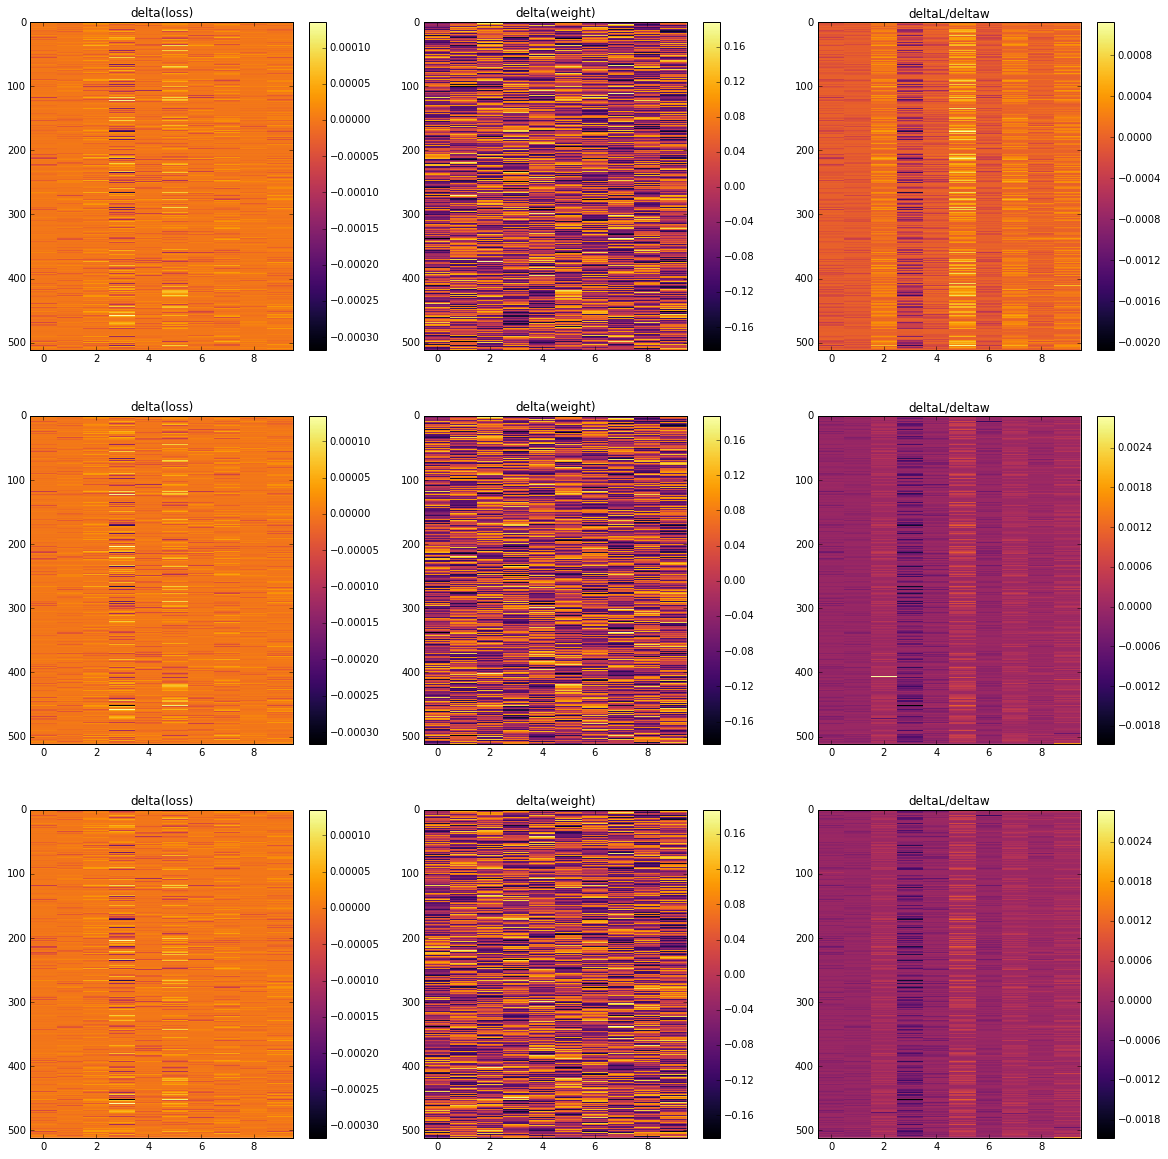

In [93]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

intp = 'None'

plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow(l_diff, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(332)
plt.imshow(w_diff, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(333)
plt.imshow(l_diff/w_diff, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

plt.subplot(334)
plt.imshow(l_diff100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(335)
plt.imshow(w_diff100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(336)
plt.imshow(l_diff100/w_diff100, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

plt.subplot(337)
plt.imshow(l_diff200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(loss)')
plt.colorbar()

plt.subplot(338)
plt.imshow(w_diff200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('delta(weight)')
plt.colorbar()

plt.subplot(339)
plt.imshow(l_diff200/w_diff200, cmap='inferno', aspect='auto', interpolation='none')
plt.title('deltaL/deltaw')
plt.colorbar()

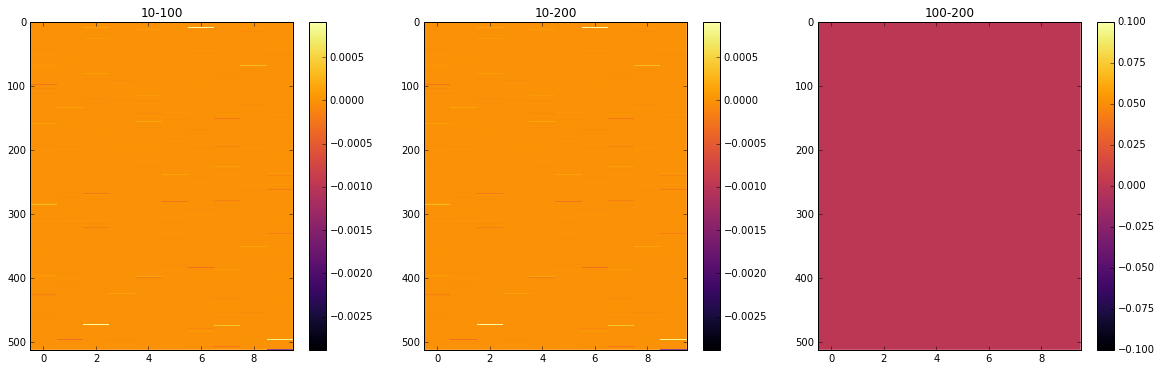

In [95]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.imshow((l_diff/w_diff) - (l_diff100/w_diff100), cmap='inferno', aspect='auto', interpolation='none')
plt.title('10-100')
plt.colorbar()

plt.subplot(332)
plt.imshow((l_diff/w_diff) - (l_diff200/w_diff200), cmap='inferno', aspect='auto', interpolation='none')
plt.title('10-200')
plt.colorbar()

plt.subplot(333)
plt.imshow((l_diff100/w_diff100) - (l_diff200/w_diff200), cmap='inferno', aspect='auto', interpolation='none')
plt.title('100-200')
plt.colorbar()


# Trying to figure out the proper value for incrementing weight
 - run another epoch, get the mode of weight difference

In [6]:
layers_weights = [model.layers[0].get_weights(), model.layers[2].get_weights(),model.layers[4].get_weights()]

# for backup purpose if we did something wrong, we can get the weight right here, no need to train the whole network
orignial_layers_weight = np.copy(layers_weights)

# for altering purpose make changes then put back into the network
layer_4_altered_weight = np.copy(layers_weights[2])

# to keep track of rate of change wrt the loss and weight
l_wrt_w = np.zeros(layers_weights[2][0].shape + (2,))

(512, 10, 2)


In [7]:
history = model.fit(X_train_10000, Y_train,
                    batch_size=batch_size, nb_epoch=1,
                    verbose=0, validation_data=(X_test_10000, Y_test))

In [36]:
# get mode of weight differences
l4w = model.layers[4].get_weights()
d = (l4w[0] - layers_weights[2][0])

In [111]:
print(dic)
for k,v in dic.iteritems():
    print(1.0/k, v)

{1000000000: 14, 100000000: 51, 10000: 177, 1000000: 975, 10000000: 224, 100000: 3133}
1e-09 14
1e-08 51
0.0001 177
1e-06 975
1e-07 224
1e-05 3133


# Finding the nb of order that most used to represent keras's weight